# Aurora Forecasting - Part 04: Actionable Batch Inference

🗒️ This notebook is divided into the following sections:
Load the trained Kp prediction model from the Hopsworks Model Registry.

Retrieve the most recent solar wind features.

Predict the current Kp index.

Retrieve the latest cloud cover for Stockholm, Luleå, and Kiruna.

Apply city-specific logic to determine if an Aurora is truly visible.

In [1]:
import hopsworks
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config import HopsworksSettings
import util
import os

settings = HopsworksSettings()
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()
mr = project.get_model_registry()

2026-01-10 23:00:39,581 WARNING: UserWarning: Qin-Denton/OMNI2 data not found in current format. This module has limited functionality. Run spacepy.toolbox.update(QDomni=True) to download data.

HopsworksSettings initialized!
2026-01-10 23:00:39,588 INFO: Initializing external client
2026-01-10 23:00:39,589 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 23:00:40,359 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-10 23:00:41,278 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Step 1: Load the Registered Model

We retrieve the latest version of our Random Forest model from the registry to make our geomagnetic predictions.

In [2]:
model_obj = mr.get_model(name=settings.MODEL_NAME, version=settings.MODEL_VERSION)
model_dir = model_obj.download()
model = joblib.load(os.path.join(model_dir, "model.pkl"))
print(f"Successfully loaded {settings.MODEL_NAME} version {model_obj.version} ")

Downloading: 0.000%|          | 0/1889763 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_rf_model version 8 ONE


# Step 2: Retrieve Latest Features and Predict Kp

We fetch the most recent minute-by-minute data from NOAA. In a production environment, you would typically pull the latest data from the Online Feature Store.

In [3]:
# We pull the most recent hours to show a trend on our dashboard
# OLD BUT NOT WORK BECAUSE VERSION 5 IS CREATED AND UPDATE BY NOTEBOOK 3 THAT IS NOT RUNNED DAILY
#solar_wind_fg = fs.get_feature_group(name="aurora_solarwind_features", version=5)

#NEW ATTEMPT BY ALE
#take version 2
#solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=2)
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=6)
solar_wind_aggreated_fg = fs.get_feature_group(name="solar_wind_aggregated_fg", version=1)

#engineeer the version 5 like in notebook 3
print("Fetching fresh data from Feature Store...")

# Pulling last 24 records to generate a trend graph
solar_wind_df = solar_wind_fg.read()
solar_wind_df['date_and_time'] = pd.to_datetime(solar_wind_df['date_and_time'])
solar_wind_df=solar_wind_df.sort_values(by='date_and_time')
last_date = solar_wind_df['date_and_time'].iloc[-1]
print(f"Raw data fetched: {len(solar_wind_df)} rows. Most recent: {last_date}")
solar_wind_df

Fetching fresh data from Feature Store...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.26s) 
Raw data fetched: 51082 rows. Most recent: 2026-01-10 21:00:00+00:00


,date_and_time,by_gsm,bz_gsm,density,speed
11065,2020-01-11 13:00:00+00:00,-4.60,1.60,4.40,429.000000
25013,2020-01-11 14:00:00+00:00,-4.00,-0.30,4.60,422.000000
31935,2020-01-11 15:00:00+00:00,-3.30,-0.50,4.90,440.000000
40329,2020-01-11 16:00:00+00:00,-4.10,1.10,5.10,438.000000
35176,2020-01-11 17:00:00+00:00,-3.70,2.40,5.20,426.000000
...,...,...,...,...,...
51072,2026-01-10 17:00:00+00:00,-1.85,-6.00,3.01,485.299988
51081,2026-01-10 18:00:00+00:00,1.72,-7.10,6.16,466.500000
51076,2026-01-10 19:00:00+00:00,0.61,-5.86,1.06,450.799988
51070,2026-01-10 20:00:00+00:00,13.36,-3.05,7.56,595.700012


In [4]:
# Get last aggregated data
solar_wind_aggregated = solar_wind_aggreated_fg.read()
solar_wind_aggregated['window_start'] = pd.to_datetime(solar_wind_aggregated['window_start'])
solar_wind_aggregated['window_end'] = pd.to_datetime(solar_wind_aggregated['window_end'])
solar_wind_aggregated=solar_wind_aggregated.sort_values(by='window_start')
last_aggregated_date = solar_wind_aggregated['window_end'].iloc[-1]
print(f"Aggregated data fetched: {len(solar_wind_aggregated)} rows. Most recent: {last_aggregated_date}")
solar_wind_aggregated    

# # Keep only data from today up to 2 days ago to reduce the computational resources needed
# cutoff_date = pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=3)
# solar_wind_aggreated = solar_wind_aggreated[solar_wind_aggreated['window_end'] >= cutoff_date]
# print(f"After cutoff, aggregated data has: {len(solar_wind_aggreated)} rows from {cutoff_date} onwards.")
# solar_wind_aggreated

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 
Aggregated data fetched: 17038 rows. Most recent: 2026-01-10 21:00:00+00:00


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std,kp_index
2233,2020-01-11 12:00:00+00:00,2020-01-11 15:00:00+00:00,-4.300000,-4.60,-4.00,0.424264,0.650000,-0.30,1.60,1.343503,4.500000,4.40,4.60,0.141421,425.500000,422.000000,429.000000,4.949748,0.30
10689,2020-01-11 15:00:00+00:00,2020-01-11 18:00:00+00:00,-3.700000,-4.10,-3.30,0.400000,1.000000,-0.50,2.40,1.452584,5.066667,4.90,5.20,0.152752,434.666656,426.000000,440.000000,7.571878,1.30
9861,2020-01-11 18:00:00+00:00,2020-01-11 21:00:00+00:00,-0.133333,-1.00,1.50,1.415392,3.300000,2.70,4.40,0.953939,5.066667,5.00,5.20,0.115470,417.666656,412.000000,422.000000,5.131601,0.30
2567,2020-01-11 21:00:00+00:00,2020-01-12 00:00:00+00:00,-1.200000,-3.00,0.90,1.967232,0.100000,-0.80,1.40,1.153256,4.900000,4.70,5.10,0.200000,416.333344,409.000000,422.000000,6.658328,0.70
14013,2020-01-12 00:00:00+00:00,2020-01-12 03:00:00+00:00,-2.700000,-3.20,-2.20,0.500000,-0.600000,-1.60,0.20,0.916515,4.566667,4.30,4.70,0.230940,428.000000,426.000000,431.000000,2.645751,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17037,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,4.040000,2.29,5.00,1.517926,485.133331,475.100006,497.700012,11.511009,3.67
17034,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,3.903333,3.23,4.83,0.829538,483.799988,464.100006,505.600006,20.829546,2.67
17033,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,5.283333,3.54,6.17,1.509845,482.466675,478.899994,486.299988,3.707200,4.33
17035,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.656667,-7.20,-1.85,3.068816,-5.313334,-6.44,-3.50,1.585728,5.386667,3.01,7.71,2.350454,476.100006,465.899994,485.299988,9.738583,3.33


In [5]:
# ---------------------------------------------------------
# COMPARE DATES AND AGGREGATE IF NEEDED
# ---------------------------------------------------------
# Compare last_date (raw data) vs last_aggregated_date (aggregated data)
print(f"Last raw data timestamp: {last_date}")
print(f"Last aggregated data timestamp: {last_aggregated_date}")

# # Determine the current 3H window based on NOW
# now = pd.Timestamp.now(tz='UTC')
# # 3H windows: 00-03, 03-06, 06-09, 09-12, 12-15, 15-18, 18-21, 21-00
# current_window_start = now.floor('3H')
# current_window_end = current_window_start + pd.Timedelta(hours=3)
# print(f"\nCurrent time (UTC): {now}")
# print(f"Current 3H window: {current_window_start} to {current_window_end}")
# previous_window_start = current_window_start - pd.Timedelta(hours=3)
# previous_window_end = current_window_start
# print(f"Previous 3H window: {previous_window_start} to {previous_window_end}")

# Check if raw data is more recent than aggregated data
if pd.Timestamp(last_date) > pd.Timestamp(last_aggregated_date):
    print(f"\n✅ Raw data {last_date} is more recent than aggregated data {last_aggregated_date}. Will aggregate new data...")
    
    # Filter data that hasn't been aggregated yet
    # Get all data after the last aggregated window end
    new_data_df = solar_wind_df[solar_wind_df['date_and_time'] >= pd.Timestamp(last_aggregated_date)].copy()
    
    # Check if there is enough new data to aggregate, in this case at least 2 rows
    if len(new_data_df) >= 2:
        print(f"Found {len(new_data_df)} new rows to potentially aggregate")
        print(f"There are the potential new data to aggregate:\n {new_data_df}")
        
        # Aggregate using the same function as notebook 1
        # First, we need to add a placeholder kp_index column for the aggregation function
        # (will be NaN since we're doing inference, not training)
        new_data_df['kp_index'] = float(99.0)  # Placeholder value
        
        new_aggregated_df = util.aggregate_solar_wind_3h(
            df=new_data_df,
            time_col='date_and_time',
            feature_cols=['by_gsm', 'bz_gsm', 'density', 'speed'],
            target_col='kp_index'
        )
        
        print(f"\nNew aggregated rows created: {len(new_aggregated_df)}")
        if len(new_aggregated_df) > 0:
            print(new_aggregated_df)
            
            # Append to existing aggregated data
            solar_wind_aggregated = pd.concat([solar_wind_aggregated, new_aggregated_df], ignore_index=True)
            solar_wind_aggregated = solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
            print(f"\nTotal aggregated rows after merge: {len(solar_wind_aggregated)}")
    else:
        print("No new data to aggregate yet")
else:
    print("\n⚠️ Aggregated data is up-to-date or more recent than raw data")

solar_wind_aggregated

# # ---------------------------------------------------------
# # CHECK IF WE CAN BUILD THE CURRENT 3H WINDOW
# # ---------------------------------------------------------
# # Filter raw data for the current 3H window
# current_window_data = solar_wind_df[
#     (solar_wind_df['date_and_time'] >= current_window_start) &
#     (solar_wind_df['date_and_time'] < current_window_end)
# ].copy()

# MIN_ROWS_FOR_AGGREGATION = 20
# print(f"\n--- Current Window Analysis ---")
# print(f"Data points in current 3H window ({current_window_start} to {current_window_end}): {len(current_window_data)}")

# if len(current_window_data) >= MIN_ROWS_FOR_AGGREGATION:
#     print(f"✅ Sufficient data ({len(current_window_data)} >= {MIN_ROWS_FOR_AGGREGATION}) to aggregate current window")
    
#     # Add placeholder kp_index for aggregation
#     current_window_data['kp_index'] = float('nan')
    
#     # Aggregate the current window
#     current_window_aggregated = util.aggregate_solar_wind_3h(
#         df=current_window_data,
#         time_col='date_and_time',
#         feature_cols=['by_gsm', 'bz_gsm', 'density', 'speed'],
#         target_col='kp_index'
#     )
    
#     if len(current_window_aggregated) > 0:
#         print("\nCurrent window aggregated successfully:")
#         print(current_window_aggregated)
        
#         # Check if this window already exists in aggregated data
#         existing_window = solar_wind_aggreated[
#             solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]
#         ]
        
#         if len(existing_window) == 0:
#             # Append to aggregated data
#             solar_wind_aggreated = pd.concat([solar_wind_aggreated, current_window_aggregated], ignore_index=True)
#             solar_wind_aggreated = solar_wind_aggreated.sort_values(by='window_start').reset_index(drop=True)
#             print("\n✅ Current window added to aggregated data")
#         else:
#             # Update existing row with new aggregation (more complete data)
#             idx = solar_wind_aggreated[solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]].index[0]
#             for col in current_window_aggregated.columns:
#                 if col != 'kp_index':  # Don't overwrite kp_index if it exists
#                     solar_wind_aggreated.loc[idx, col] = current_window_aggregated[col].iloc[0]
#             print("\n✅ Current window updated in aggregated data")
# else:
#     print(f"⚠️ Insufficient data ({len(current_window_data)} < {MIN_ROWS_FOR_AGGREGATION}) for current window aggregation")
#     print("Will use the most recent complete aggregated window for inference")

# print(f"\n--- Final Aggregated Data Summary ---")
# print(f"Total aggregated rows: {len(solar_wind_aggreated)}")
# print(f"Most recent window: {solar_wind_aggreated['window_start'].iloc[-1]} to {solar_wind_aggreated['window_end'].iloc[-1]}")
# solar_wind_aggreated.tail(5)

Last raw data timestamp: 2026-01-10 21:00:00+00:00
Last aggregated data timestamp: 2026-01-10 21:00:00+00:00

⚠️ Aggregated data is up-to-date or more recent than raw data


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std,kp_index
2233,2020-01-11 12:00:00+00:00,2020-01-11 15:00:00+00:00,-4.300000,-4.60,-4.00,0.424264,0.650000,-0.30,1.60,1.343503,4.500000,4.40,4.60,0.141421,425.500000,422.000000,429.000000,4.949748,0.30
10689,2020-01-11 15:00:00+00:00,2020-01-11 18:00:00+00:00,-3.700000,-4.10,-3.30,0.400000,1.000000,-0.50,2.40,1.452584,5.066667,4.90,5.20,0.152752,434.666656,426.000000,440.000000,7.571878,1.30
9861,2020-01-11 18:00:00+00:00,2020-01-11 21:00:00+00:00,-0.133333,-1.00,1.50,1.415392,3.300000,2.70,4.40,0.953939,5.066667,5.00,5.20,0.115470,417.666656,412.000000,422.000000,5.131601,0.30
2567,2020-01-11 21:00:00+00:00,2020-01-12 00:00:00+00:00,-1.200000,-3.00,0.90,1.967232,0.100000,-0.80,1.40,1.153256,4.900000,4.70,5.10,0.200000,416.333344,409.000000,422.000000,6.658328,0.70
14013,2020-01-12 00:00:00+00:00,2020-01-12 03:00:00+00:00,-2.700000,-3.20,-2.20,0.500000,-0.600000,-1.60,0.20,0.916515,4.566667,4.30,4.70,0.230940,428.000000,426.000000,431.000000,2.645751,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17037,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,4.040000,2.29,5.00,1.517926,485.133331,475.100006,497.700012,11.511009,3.67
17034,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,3.903333,3.23,4.83,0.829538,483.799988,464.100006,505.600006,20.829546,2.67
17033,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,5.283333,3.54,6.17,1.509845,482.466675,478.899994,486.299988,3.707200,4.33
17035,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.656667,-7.20,-1.85,3.068816,-5.313334,-6.44,-3.50,1.585728,5.386667,3.01,7.71,2.350454,476.100006,465.899994,485.299988,9.738583,3.33


In [6]:
# Drop kp_index column before saving
solar_wind_aggregated = solar_wind_aggregated.drop(columns=['kp_index'], errors='ignore')

# Keep onyl the last 100 rows to limit size
solar_wind_aggregated = solar_wind_aggregated.tail(100).reset_index(drop=True)
solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std
0,2025-11-29 21:00:00+00:00,2025-11-30 00:00:00+00:00,2.666667,2.10,3.00,0.493288,-0.833333,-1.40,0.00,0.737111,4.066667,3.80,4.30,0.251661,617.666687,611.000000,621.000000,5.773503
1,2025-11-30 00:00:00+00:00,2025-11-30 03:00:00+00:00,2.500000,0.60,3.60,1.652271,-2.366667,-3.70,-1.70,1.154701,3.966666,3.40,4.30,0.493288,620.666687,618.000000,622.000000,2.309401
2,2025-11-30 03:00:00+00:00,2025-11-30 06:00:00+00:00,3.166667,2.50,3.70,0.611010,0.266667,-0.40,1.00,0.702377,2.800000,2.70,2.90,0.100000,627.333313,617.000000,637.000000,10.016653
3,2025-11-30 06:00:00+00:00,2025-11-30 09:00:00+00:00,1.200000,0.10,2.50,1.212436,-0.166667,-1.70,0.70,1.331666,2.366667,2.20,2.60,0.208167,602.333313,593.000000,620.000000,15.307950
4,2025-11-30 09:00:00+00:00,2025-11-30 12:00:00+00:00,0.800000,-1.00,3.90,2.696294,-0.333333,-1.20,0.60,0.901850,2.933333,2.50,3.20,0.378594,586.333313,577.000000,597.000000,10.066446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,4.040000,2.29,5.00,1.517926,485.133331,475.100006,497.700012,11.511009
96,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,3.903333,3.23,4.83,0.829538,483.799988,464.100006,505.600006,20.829546
97,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,5.283333,3.54,6.17,1.509845,482.466675,478.899994,486.299988,3.707200
98,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.656667,-7.20,-1.85,3.068816,-5.313334,-6.44,-3.50,1.585728,5.386667,3.01,7.71,2.350454,476.100006,465.899994,485.299988,9.738583


In [7]:
solar_wind_aggregated = util.lag_features(solar_wind_aggregated, lags=[1, 2], feature_cols=["bz_gsm_mean", "bz_gsm_min", "speed_mean", "density_mean"])
solar_wind_aggregated

# Calculate dynamic pressure
solar_wind_aggregated['dynamic_pressure'] = solar_wind_aggregated['density_mean'] * (solar_wind_aggregated['speed_mean'] ** 2)

solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,speed_std,bz_gsm_mean_lag_1,bz_gsm_mean_lag_2,bz_gsm_min_lag_1,bz_gsm_min_lag_2,speed_mean_lag_1,speed_mean_lag_2,density_mean_lag_1,density_mean_lag_2,dynamic_pressure
0,2025-11-29 21:00:00+00:00,2025-11-30 00:00:00+00:00,2.666667,2.10,3.00,0.493288,-0.833333,-1.40,0.00,0.737111,...,5.773503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.551483e+06
1,2025-11-30 00:00:00+00:00,2025-11-30 03:00:00+00:00,2.500000,0.60,3.60,1.652271,-2.366667,-3.70,-1.70,1.154701,...,2.309401,-0.833333,NaN,-1.40,NaN,617.666687,NaN,4.066667,NaN,1.528068e+06
2,2025-11-30 03:00:00+00:00,2025-11-30 06:00:00+00:00,3.166667,2.50,3.70,0.611010,0.266667,-0.40,1.00,0.702377,...,10.016653,-2.366667,-0.833333,-3.70,-1.40,620.666687,617.666687,3.966666,4.066667,1.101932e+06
3,2025-11-30 06:00:00+00:00,2025-11-30 09:00:00+00:00,1.200000,0.10,2.50,1.212436,-0.166667,-1.70,0.70,1.331666,...,15.307950,0.266667,-2.366667,-0.40,-3.70,627.333313,620.666687,2.800000,3.966666,8.586394e+05
4,2025-11-30 09:00:00+00:00,2025-11-30 12:00:00+00:00,0.800000,-1.00,3.90,2.696294,-0.333333,-1.20,0.60,0.901850,...,10.066446,-0.166667,0.266667,-1.70,-0.40,602.333313,627.333313,2.366667,2.800000,1.008441e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,...,11.511009,0.483333,4.123333,-4.45,0.05,479.466675,479.899994,4.663333,5.710000,9.508316e+05
96,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,...,20.829546,-4.330000,0.483333,-6.25,-4.45,485.133331,479.466675,4.040000,4.663333,9.136237e+05
97,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,...,3.707200,-4.856667,-4.330000,-8.41,-6.25,483.799988,485.133331,3.903333,4.040000,1.229823e+06
98,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.656667,-7.20,-1.85,3.068816,-5.313334,-6.44,-3.50,1.585728,...,9.738583,-5.576667,-4.856667,-6.94,-8.41,482.466675,483.799988,5.283333,3.903333,1.221002e+06


In [8]:
# # ---------------------------------------------------------
# # FEATURE ENGINEERING (Must match Notebook 3 exactly)
# # ---------------------------------------------------------
# # A. Create Lags
# LAGS = [1, 2, 3, 4]
# for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
#     for lag in LAGS:
#         solar_wind_df[f"{col}_lag_{lag}"] = solar_wind_df[col].shift(lag)

# # B. Create Rolling Statistics
# WINDOWS = [2, 4]
# for col in ['bz_gsm', 'speed', 'density']:
#     for w in WINDOWS:
#         solar_wind_df[f"{col}_roll_mean_{w}"] = solar_wind_df[col].rolling(w).mean()
#         solar_wind_df[f"{col}_roll_std_{w}"] = solar_wind_df[col].rolling(w).std()

# # C. Create Dynamic Pressure
# # Formula: density * speed^2 (simplified representation used in training)
# solar_wind_df['dynamic_pressure'] = solar_wind_df['density'] * (solar_wind_df['speed'] ** 2)

# # D. Cleanup
# # The first few rows will contain NaNs due to shifting/rolling.
# # We drop them to ensure clean input for the model.
# df_clean = solar_wind_df.dropna().copy()

# print(f"Data processed. Available for inference: {len(df_clean)} rows.")

In [9]:
latest_record = solar_wind_aggregated.iloc[[-1]] # Double brackets keeps it as a DataFrame
latest_time = latest_record['window_start'].values[0]
print(f"Latest record is:\n {latest_record}")
prediction_window_start = latest_time + pd.Timedelta(hours=3)
prediction_window_end = latest_time + pd.Timedelta(hours=6)

print(f"Performing inference for time window: {prediction_window_start} --->> {prediction_window_end}")

# 2. Prepare Feature Vector (Drop non-feature columns)
# The model expects only specific columns. We must drop ID/Target columns.
features_df = latest_record.drop(columns=['window_start', 'window_end', 'kp_index'], errors='ignore')
features_df.to_string()

# Reorder columns to match model's expected order
expected_order = model.get_booster().feature_names
features_df = features_df[expected_order]

# 3. Predict
predicted_kp = model.predict(features_df)[0]

print(f"✅ PREDICTED Kp INDEX: {predicted_kp:.2f}")

Latest record is:
                 window_start                window_end  by_gsm_mean  \
99 2026-01-10 18:00:00+00:00 2026-01-10 21:00:00+00:00         5.23   

    by_gsm_min  by_gsm_max  by_gsm_std  bz_gsm_mean  bz_gsm_min  bz_gsm_max  \
99        0.61       13.36    7.062627    -5.336667        -7.1       -3.05   

    bz_gsm_std  ...  speed_std  bz_gsm_mean_lag_1  bz_gsm_mean_lag_2  \
99    2.075098  ...  79.514297          -5.313334          -5.576667   

    bz_gsm_min_lag_1  bz_gsm_min_lag_2  speed_mean_lag_1  speed_mean_lag_2  \
99             -6.44             -6.94        476.100006        482.466675   

    density_mean_lag_1  density_mean_lag_2  dynamic_pressure  
99            5.386667            5.283333       1253108.125  

[1 rows x 27 columns]
Performing inference for time window: 2026-01-10 21:00:00 --->> 2026-01-11 00:00:00
✅ PREDICTED Kp INDEX: 4.73


DA QUI COMMENTO UN ATTIMO

In [10]:
# Prepare features for the model (ensuring they match the training columns)
# Drop 'time' and the target 'kp_index' to isolate features

#features_df = recent_data.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

In [11]:
# 4. Predict Kp Index for the whole window
#recent_data['predicted_kp'] = model.predict(features_df)
#latest_prediction = recent_data.iloc[-1]
#predicted_kp = latest_prediction['predicted_kp']

#print(f"\n>>> Current Predicted Global Kp Index: {predicted_kp:.2f}")

FINE PARTE COMMENTATA

In [12]:
# 5. Local Visibility and Actionable Decisions
results = []

for city, city_conf in settings.CITIES.items():
    cloud_cover_df = util.get_city_weather_forecast(city_conf['lat'], city_conf['lon'], hours_ahead=4)
    print(cloud_cover_df)
    # Calculate the average cloud cover over the forecast period
    cloud_cover = cloud_cover_df['cloud_cover'].mean()
    status = util.aurora_visibility_logic(
        pred_kp=predicted_kp,
        kp_threshold=city_conf['kp_threshold'],
        cloud_cover=cloud_cover
    )
    
    results.append({
        "city": city,
        "prediction_window_start": prediction_window_start,
        "prediction_window_end": prediction_window_end,
        "predicted_kp": round(predicted_kp, 2),
        "cloud_cover_mean": cloud_cover,
        "status": status
    })

inference_df = pd.DataFrame(results)
print("\n--- Current Visibility Status ---")
print(inference_df[['city', 'predicted_kp', 'cloud_cover', 'status']])
inference_df

                 time  cloud_cover
0 2026-01-10 23:00:00            2
1 2026-01-11 00:00:00            2
2 2026-01-11 01:00:00            4
3 2026-01-11 02:00:00            3
                 time  cloud_cover
0 2026-01-10 23:00:00          100
1 2026-01-11 00:00:00           96
2 2026-01-11 01:00:00           79
3 2026-01-11 02:00:00           77
                 time  cloud_cover
0 2026-01-10 23:00:00          100
1 2026-01-11 00:00:00          100
2 2026-01-11 01:00:00          100
3 2026-01-11 02:00:00          100

--- Current Visibility Status ---


KeyError: "['cloud_cover'] not in index"

In [ ]:
# 6. Update Monitoring Feature Group
monitor_fg = fs.get_or_create_feature_group(
    name="aurora_monitoring_fg",
    version=3,
    primary_key=['city', 'prediction_window_start', 'prediction_window_end'],
    event_time="prediction_window_start",
    description="Actual vs Predicted visibility signals for monitoring"
)
monitor_fg.insert(inference_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fg/1908194


Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aurora_monitoring_fg_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_monitoring_fg_3_offline_fg_materialization/executions


(Job('aurora_monitoring_fg_3_offline_fg_materialization', 'SPARK'), None)

Dashboard


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


KeyError: 'predicted_kp'

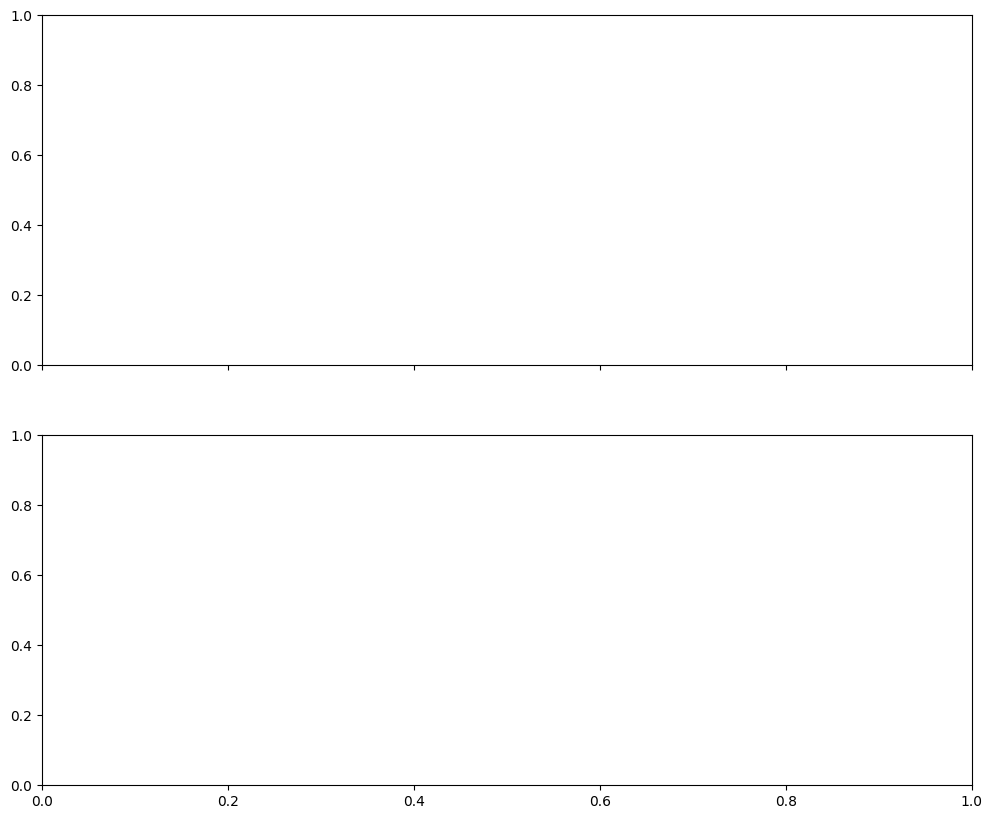

In [ ]:
# 7. VISUAL DASHBOARD GENERATION
# We pull the history of predictions to show the timeline
history_df = monitor_fg.read().sort_values(by='prediction_window_end')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Kp Index Trend
ax1.plot(solar_wind_df['date_and_time'], solar_wind_df['predicted_kp'], color='blue', linewidth=2, label='Predicted Kp Trend')
ax1.axhline(y=predicted_kp, color='red', linestyle='--', alpha=0.5, label='Current Level')
ax1.set_ylabel('Kp Index (Intensity)', fontsize=12)
ax1.set_ylim(0, 9)
ax1.set_title('Global Geomagnetic Activity Trend (Last 24h)', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: City Visibility Timeline (The "Go" signal)
colors = {'Kiruna': 'forestgreen', 'Luleå': 'orange', 'Stockholm': 'purple'}
for i, city in enumerate(settings.CITIES.keys()):
    city_hist = history_df[history_df['city'] == city].tail(24).copy()
    # Map "GO" to 1, others to 0 for plotting
    city_hist['go_val'] = city_hist['status'].apply(lambda x: 1 if x == "GO" else 0)
    
    # Offset the city lines slightly so they are all visible
    ax2.step(city_hist['time'], city_hist['go_val'] + (i * 0.05), label=f'{city} Visibility', color=colors[city], where='post')

ax2.set_ylabel('Visibility (GO = High Probability)', fontsize=12)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No Activity', 'GO Signal'])
ax2.set_title('Actionable Visibility per City', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

plt.xlabel('Time (UTC)', fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()

# Save the dashboard
dashboard_path = "aurora_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')
print(f"\nDashboard saved as {dashboard_path}")
plt.show()

# 8. Upload to Hopsworks Resources
dataset_api = project.get_dataset_api()
if not dataset_api.exists("Resources/aurora"):
    dataset_api.mkdir("Resources/aurora")

# Upload the latest dashboard for public viewing
dataset_api.upload(dashboard_path, "Resources/aurora/latest_dashboard.png", overwrite=True)
# Upload a timestamped version for history
current_time = datetime.datetime.utcnow()
timestamp = current_time.strftime('%Y%m%d_%H%M')
dataset_api.upload(dashboard_path, f"Resources/aurora/history/dashboard_{timestamp}.png", overwrite=True)

print(f"Dashboard uploaded to Hopsworks: Resources/aurora/latest_dashboard.png")

# Save the dashboard into the docs folder for GitHub Pages
dashboard_path = "docs/aurora/assets/img/latest_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')